# Fundamentals

This brief introduction into the fluid dynamics in a compartment fire is based on a characteristic setup and simulations carried out. 

## Setup

The compartment has an extension of 

$$
\mf I_{compartment} = [0.20~m, 2.70~m] \times [-1.40~m, 1.40~m] \times [0.05~m, 2.00~m]
$$

and is embeded in a computational domain of 

$$
\mf I_{domain} = [0.00~m, 4.80~m] \times [-1.80~m, 1.80~m] \times [0.00~m, 3.00~m] \quad .
$$

```{margin}
See the [FDS introduction section](../../tools/01_fds_smv/02_fds_tutorial) for a quick introduction on how to define a computational domain and obstacles.
```

The compartment is build out of individual obstacles, creating the walls, the floor and the ceiling. One of the walls contains an opening, see {numref}`fig-compartment-setup`. The domain boundaries are defined as open boundaries. 

:::{figure-md} fig-compartment-setup

<img src="./figs/compartment_fire_setup_01.png" width="60%">

Setup for the compartment fire example. There is only one single opening, i.e. the door. The surface with a predefined heat release rate is indicated in red.
:::

The heat release rate is defined as a constant value of $\mf 10~kW$ and the patch emitting the fuel has a surface temperature of $\mf 100~^\circ C$.

For demonstration purposes, all quantities are visualised in the symmetry plane at $\mf y=0$, see {numref}`fig-compartment-slcf-temp`.

:::{figure-md} fig-compartment-slcf-temp

<img src="./figs/compartment_fire_slcf_temp_01.png" width="60%">

Temperature field in the $\mf y=0~m$ plane.
:::


````{admonition} Full FDS input file
:class: dropdown

```{literalinclude} ../../../../data/compartment/pressure_01/compartment.fds
```
````

## Flow 

```{margin}
See [introduction to the fdsreader module section](../../tools/03_analysis/02_fdsreader) for a quick introduction on how to read in FDS data in Python.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fdsreader

plt.rcParams['figure.dpi'] = 150

In [2]:
path_to_data = '../../../../data/compartment/pressure_01/rundir/'

sim = fdsreader.Simulation(path_to_data)

Slice([3D] cell_centered=True, extent=Extent([0.00, 4.80] x [0.00, 0.05] x [0.00, 3.00]))


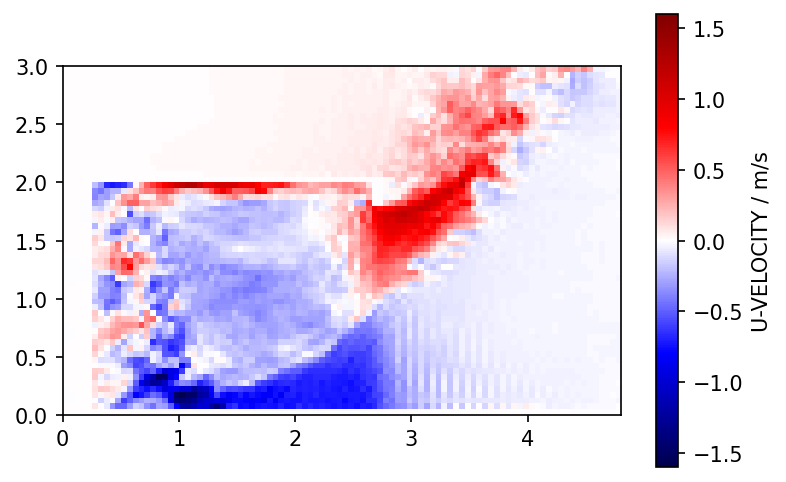

Slice([3D] cell_centered=True, extent=Extent([0.00, 4.80] x [0.00, 0.05] x [0.00, 3.00]))


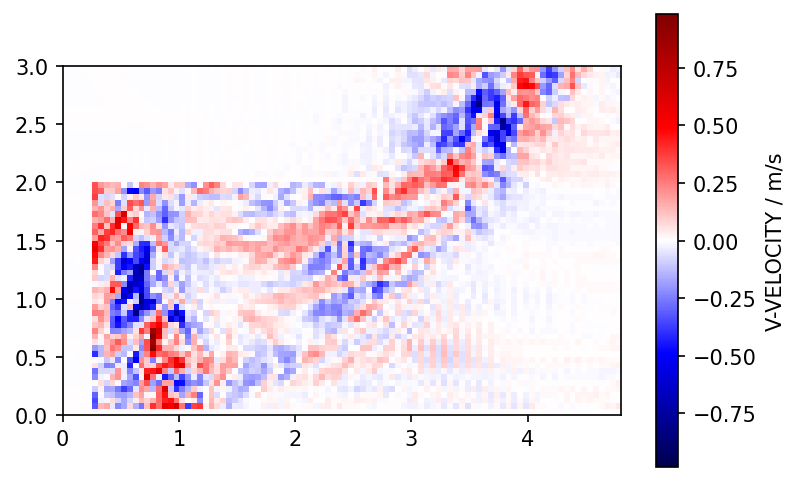

Slice([3D] cell_centered=True, extent=Extent([0.00, 4.80] x [0.00, 0.05] x [0.00, 3.00]))


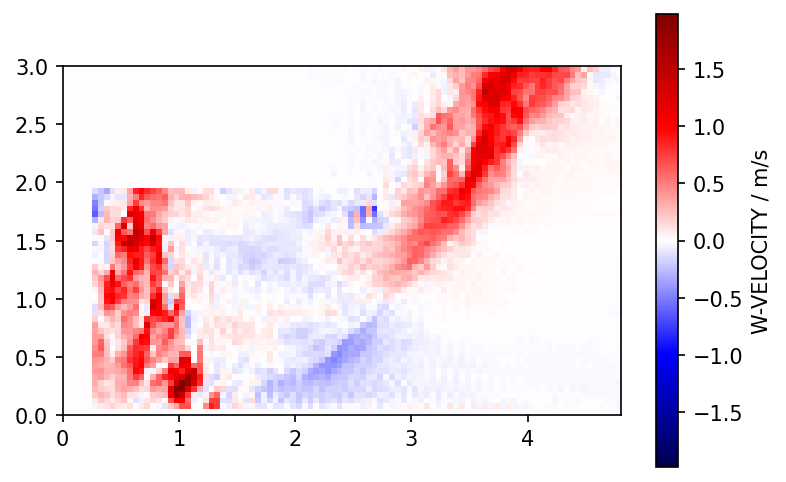

In [3]:
list_q = ['U-VELOCITY', 'V-VELOCITY', 'W-VELOCITY']
it = sim.slices[0].get_nearest_timestep(250)
for q in list_q:
    slice = sim.slices.filter_by_quantity(q)[0]
    
    print(slice)
    ### fds / fdsreader BUG workaround BEGIN
    ### Issue due to SLCF located at MESH boundary
    to_del = []
    for s in slice:
        if s.extent._extents[1][0] > 0:
            to_del.append(s.mesh)
    for m in to_del:
        del slice._subslices[m]
        
    extent = (slice.extent[0][0], slice.extent[0][1], 
              slice.extent[2][0], slice.extent[2][1])
#     print(extent)
    ### fds / fdsreader BUG workaround END
    
    slice_data = slice.to_global()
    
    v_abs_max = np.max(np.abs(slice_data[it]))
    
    plt.imshow(slice_data[it].T,
               vmin = -v_abs_max, vmax = v_abs_max,
               origin='lower', 
               extent=extent,
               cmap='seismic')
    q = slice.quantity.quantity
    u = slice.quantity.unit
    plt.colorbar(label=f"{q} / {u}")
    plt.show()

In [4]:
u_slice = sim.slices.filter_by_quantity('U-VELOCITY')[0]
slice_data = u_slice.to_global()

In [5]:
x0 = 2.7
ix = u_slice.get_nearest_index('x', x0)
print(f'Index in x-direction next to x={x0} is {ix}.')

z0 = 1.5
iy = u_slice.get_nearest_index('y', z0)
print(f'Index in z-direction next to z={z0} is {iy}.')

Index in x-direction next to x=2.7 is 54.
Index in z-direction next to z=1.5 is 35.


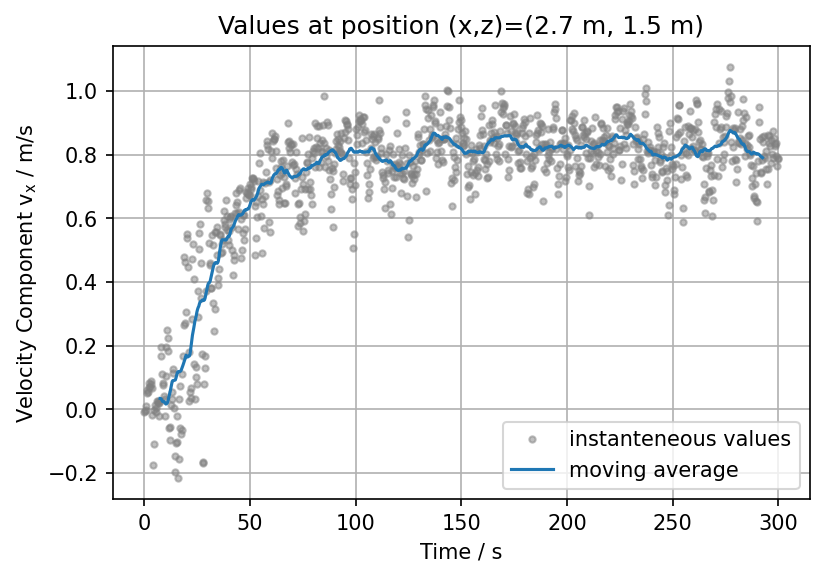

In [6]:
instant_values = slice_data[:, ix, iy]
n_a = 51
average_values = np.convolve(instant_values, np.ones(n_a)/n_a, mode='valid')
plt.plot(u_slice.times, instant_values, '.', color='grey', alpha=0.5, label='instanteneous values')
plt.plot(u_slice.times[n_a//2:-(n_a//2)], average_values, label='moving average')
plt.xlabel('Time / s')
plt.ylabel('Velocity Component $\sf v_x$ / m/s')
plt.grid()
plt.legend()
plt.title(f'Values at position (x,z)=({x0} m, {z0} m)');

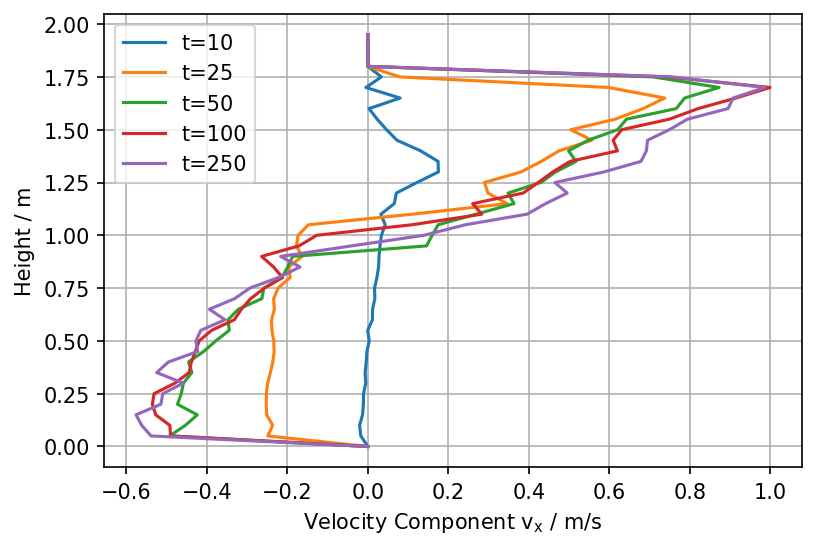

In [7]:
z_max = 2.0
iz_max = u_slice.get_nearest_index('y', z_max) 

### TODO: quick solution, needs fix
h = np.arange(0, z_max, 0.05)

list_t = [10, 25, 50, 100, 250]

for t in list_t:
    it = sim.slices[0].get_nearest_timestep(t)
    plt.plot(slice_data[it, ix, 0:iz_max+5], h, label=f't={t}')

plt.xlabel('Velocity Component $\sf v_x$ / m/s')
plt.ylabel('Height / m')
plt.grid()
plt.legend()

## Pressure

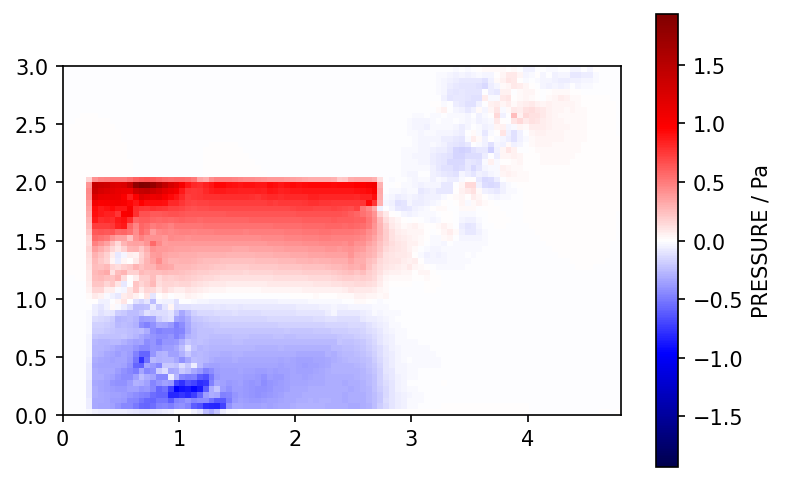

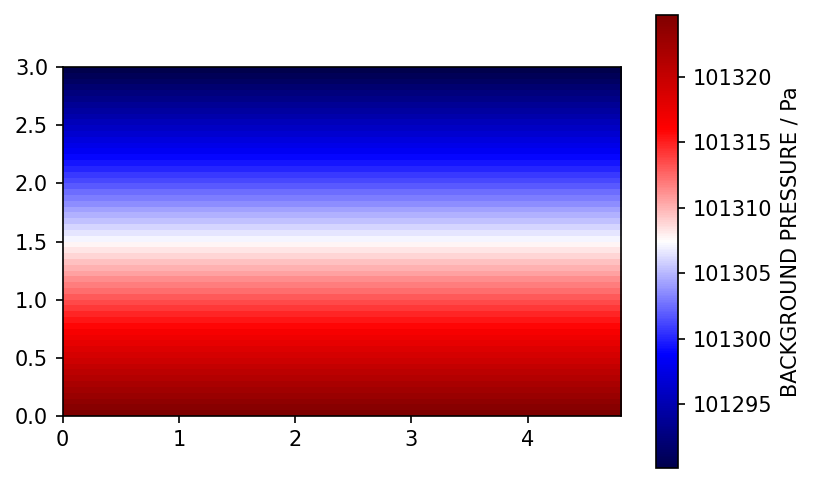

In [8]:
list_q = ['PRESSURE', 'BACKGROUND PRESSURE']

it = sim.slices[0].get_nearest_timestep(250)

for q in list_q:
    slice = sim.slices.filter_by_quantity(q)[0]
    
#     print(slice)
    ### fds / fdsreader BUG workaround BEGIN
    ### Issue due to SLCF located at MESH boundary
    to_del = []
    for s in slice:
        if s.extent._extents[1][0] > 0:
            to_del.append(s.mesh)
    for m in to_del:
        del slice._subslices[m]
        
    extent = (slice.extent[0][0], slice.extent[0][1], 
              slice.extent[2][0], slice.extent[2][1])
#     print(extent)
    ### fds / fdsreader BUG workaround END
    
    slice_data = slice.to_global()
    
    if np.min(slice_data[it]) < 0:
        v_abs_max = np.max(np.abs(slice_data[it]))
        vmin = -v_abs_max
        vmax = v_abs_max
    else:
        vmin = np.min(slice_data[it])
        vmax = np.max(slice_data[it])
    
    plt.imshow(slice_data[it].T,
               vmin = vmin, vmax = vmax,
               origin='lower', 
               extent=extent,
               cmap='seismic')
    q = slice.quantity.quantity
    u = slice.quantity.unit
    plt.colorbar(label=f"{q} / {u}")
    plt.show()

In [9]:
p1_slice = sim.slices.filter_by_quantity('PRESSURE')[0]
p1_data = p1_slice.to_global()
p2_slice = sim.slices.filter_by_quantity('BACKGROUND PRESSURE')[0]
p2_data = p2_slice.to_global()
p2_data -= np.mean(p2_data)
p_data = p1_data + p2_data

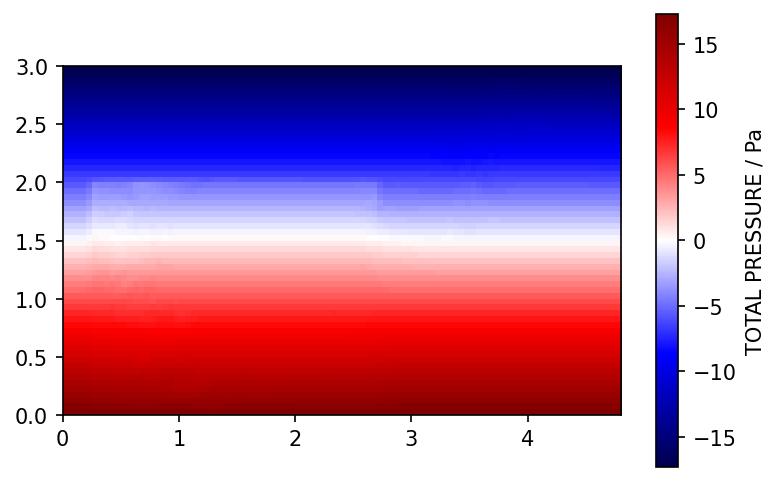

In [10]:
plt.imshow(p_data[it].T,
           origin='lower', 
           extent=extent,
           cmap='seismic')
q = "TOTAL PRESSURE"
u = "Pa"
plt.colorbar(label=f"{q} / {u}")
plt.show()

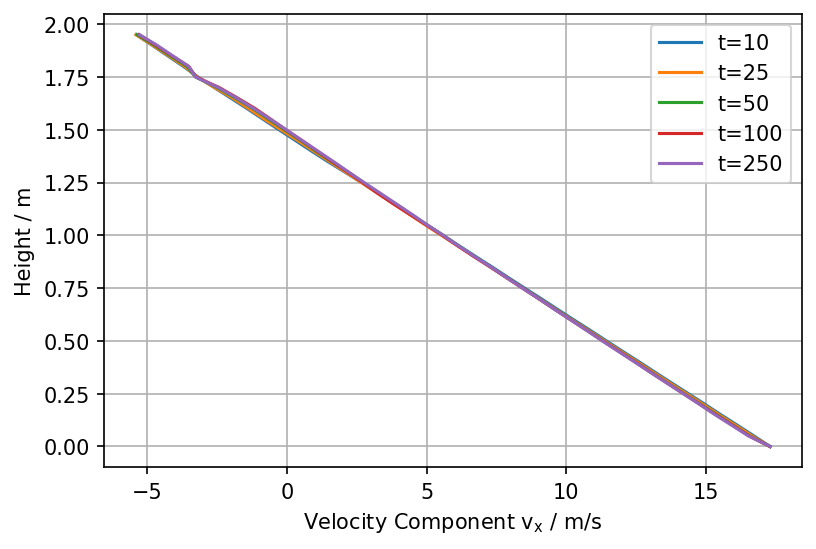

In [11]:
z_max = 2.0
iz_max = u_slice.get_nearest_index('y', z_max) 

### TODO: quick solution, needs fix
h = np.arange(0, z_max, 0.05)

list_t = [10, 25, 50, 100, 250]

for t in list_t:
    it = sim.slices[0].get_nearest_timestep(t)
    plt.plot(p_data[it, ix, 0:iz_max+5], h, label=f't={t}')

plt.xlabel('Velocity Component $\sf v_x$ / m/s')
plt.ylabel('Height / m')
plt.grid()
plt.legend()

## Other Quantities

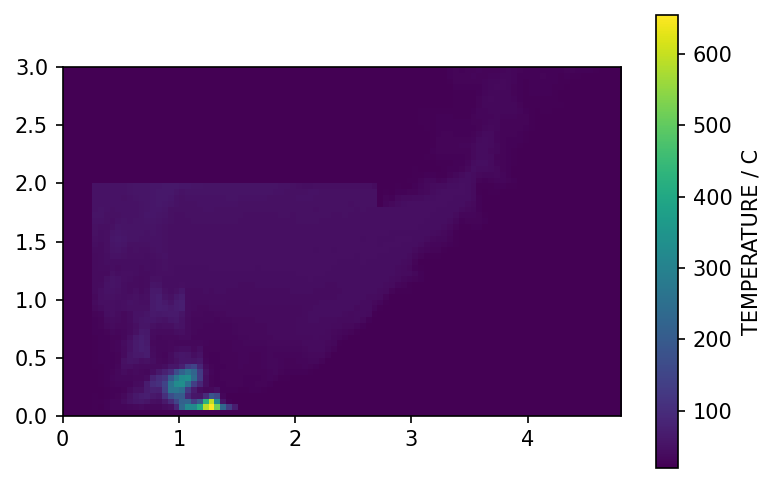

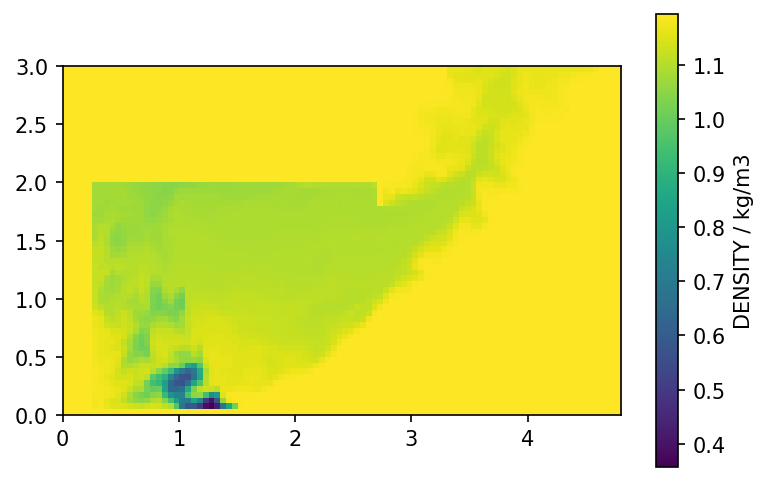

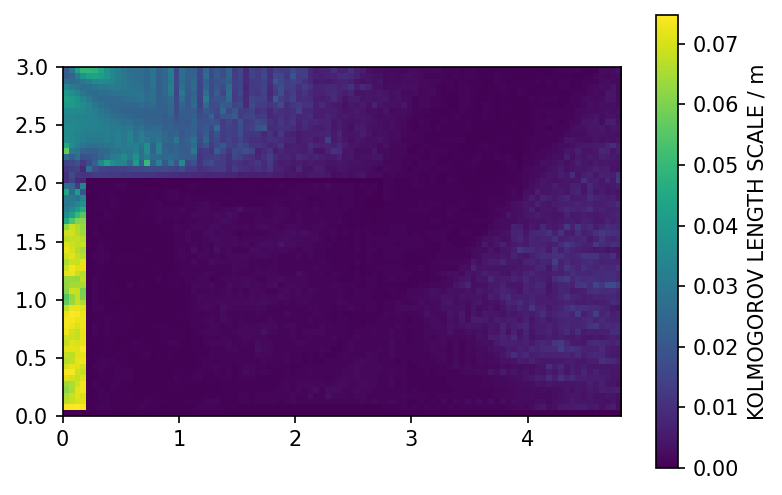

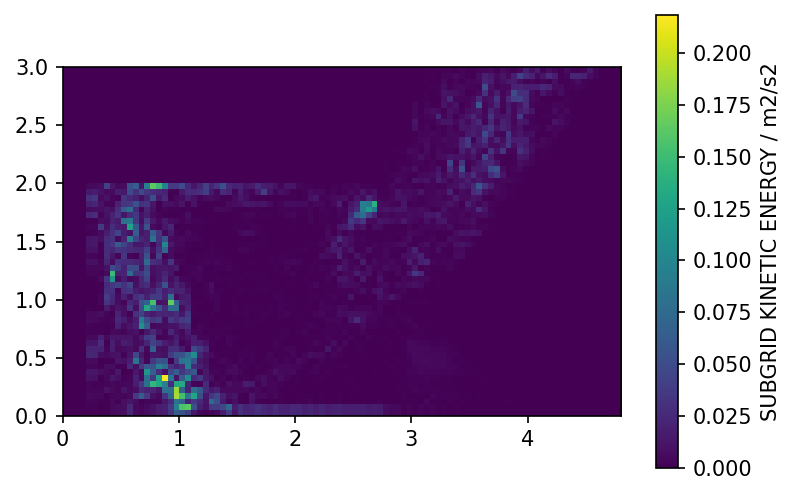

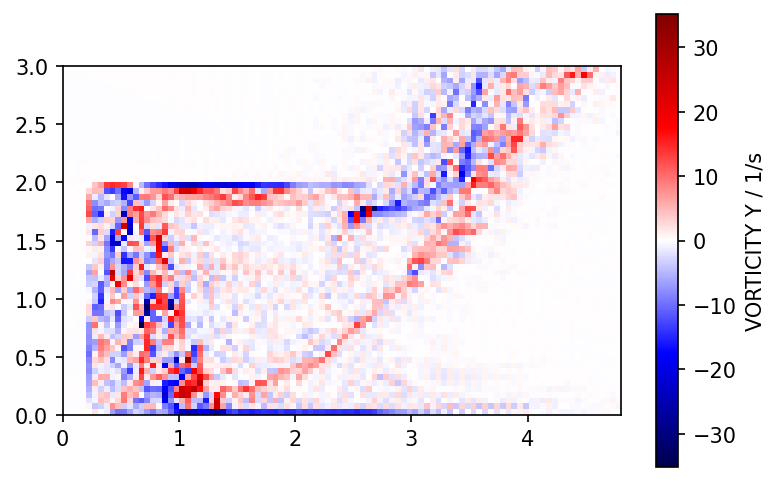

In [12]:
list_q = ['TEMPERATURE', 'DENSITY', 'KOLMOGOROV LENGTH SCALE', 'SUBGRID KINETIC ENERGY', 'VORTICITY Y']
it = sim.slices[0].get_nearest_timestep(250)
for q in list_q:
    slice = sim.slices.filter_by_quantity(q)[0]
    
#     print(slice)
    ### fds / fdsreader BUG workaround BEGIN
    ### Issue due to SLCF located at MESH boundary
    to_del = []
    for s in slice:
        if s.extent._extents[1][0] > 0:
            to_del.append(s.mesh)
    for m in to_del:
        del slice._subslices[m]
        
    extent = (slice.extent[0][0], slice.extent[0][1], 
              slice.extent[2][0], slice.extent[2][1])
#     print(extent)
    ### fds / fdsreader BUG workaround END
    
    slice_data = slice.to_global()
    
    if np.min(slice_data[it]) < 0:
        v_abs_max = np.max(np.abs(slice_data[it]))
        vmin = -v_abs_max
        vmax = v_abs_max
        cmap='seismic'
    else:
        vmin = np.min(slice_data[it])
        vmax = np.max(slice_data[it])
        cmap='viridis'
    
    plt.imshow(slice_data[it].T,
               vmin = vmin, vmax = vmax,
               origin='lower', 
               extent=extent,
               cmap=cmap)
    q = slice.quantity.quantity
    u = slice.quantity.unit
    plt.colorbar(label=f"{q} / {u}")
    plt.show()